# BetterWrapped

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import os
import time
import pycountry

## Loading API-Keys

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

## Importing Spotify data

### Reading data

In [5]:
df_raw = pd.DataFrame()
for file in [x for x in os.listdir("Spotify Extended Streaming History") if x.startswith("Streaming_History_Audio")]:
    df_raw = pd.concat([df_raw, pd.read_json("Spotify Extended Streaming History/"+file)])
df_raw.sample(3)

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
9246,2020-07-30T14:12:04Z,"Android OS 10 API 29 (Xiaomi, Mi A3)",183026,CH,194.230.147.5,So Am I,Ava Max,So Am I,spotify:track:0uUNN1nSoUx1A4fkDCWDQ7,None,...,NaN,NaN,NaN,clickrow,trackdone,False,False,False,NaN,False
2796,2019-05-20T16:43:57Z,Windows 10 (10.0.17134; x64),2790,CH,84.74.88.79,Bring It Back,MOTi,Bring It Back,spotify:track:77mXgNePTK6pTC9afLQvi3,None,...,NaN,NaN,NaN,clickrow,endplay,False,False,False,NaN,False
8049,2021-09-17T22:03:32Z,"Android OS 9 API 28 (LGE, LG-H870)",1824,CH,194.230.144.95,Magic In The Hamptons (feat. Lil Yachty),Social House,Magic In The Hamptons (feat. Lil Yachty),spotify:track:2Yer0p7uB2lVBUAtANuuQp,None,...,NaN,NaN,NaN,fwdbtn,fwdbtn,False,False,False,NaN,False


### Formatting and cleaning data

In [6]:
df = df_raw.drop(columns=["episode_name", "episode_show_name", "spotify_episode_uri", "audiobook_title", "audiobook_uri", "audiobook_chapter_uri", "audiobook_chapter_title"])
df.rename(columns={"conn_country":"country_code", "ip_addr":"ip", "master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name", "master_metadata_album_album_name":"album_name"}, inplace=True)
df["ts"] = pd.to_datetime(df["ts"])
df["ts"] = df["ts"].dt.tz_localize(None)
df = df.dropna(subset=["artist_name"])
df["s_played"] = df["ms_played"]/1000
df["min_played"] = df["s_played"]/60
df["h_played"] = df["min_played"]/60
df["d_played"] = df["h_played"]/24
df["country_name"] = df["country_code"].map(lambda x : pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else "Unbekannt")
df["date"] = df["ts"].dt.date
df["year"] = df["ts"].dt.year
df["month"] = df["ts"].dt.month
df["day"] = df["ts"].dt.day
df["time"] = df["ts"].dt.time
df["hour"] = df["ts"].dt.hour
df["minute"] = df["ts"].dt.minute
df["second"] = df["ts"].dt.second
df["spotify_track_uri"] = df["spotify_track_uri"].str.split(':').str[-1]
df.sample(3)

,ts,platform,ms_played,country_code,ip,track_name,artist_name,album_name,spotify_track_uri,reason_start,...,d_played,country_name,date,year,month,day,time,hour,minute,second
5326,2024-03-06 17:23:05,ios,330947,CH,194.230.160.173,On My Way Out,Getter,Visceral,63ZBpjiKp43aa6xkursp5E,fwdbtn,...,0.003830,Switzerland,2024-03-06,2024,3,6,17:23:05,17,23,5
8727,2020-07-22 04:32:02,"Android-tablet OS 10 API 29 (Xiaomi, Mi A3)",10851,CH,194.230.147.168,Banana (feat. Shaggy) - DJ FLe - Minisiren Remix,Conkarah,Banana (feat. Shaggy),0dZpw3h6KZhcHec61qwevZ,trackdone,...,0.000126,Switzerland,2020-07-22,2020,7,22,04:32:02,4,32,2
4246,2024-01-30 15:43:39,ios,228720,CH,84.72.9.181,S&M,Rihanna,Loud,7ySUcLPVX7KudhnmNcgY2D,trackdone,...,0.002647,Switzerland,2024-01-30,2024,1,30,15:43:39,15,43,39


## Fetching data

In [7]:
import requests

In [8]:
if not "fetched_data" in os.listdir():
    os.mkdir("fetched_data")

### Fetching genres

https://developer.spotify.com/

In [9]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

In [10]:
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [11]:
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [12]:
def fetch_artist_genre(sp, artist, max_retries=5, initial_wait=5):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            genre = sp.search(q=artist, type="artist")["artists"]["items"][0]["genres"]
            return genre
        except (requests.exceptions.ReadTimeout, SpotifyException):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [13]:
if not "artist_genre.csv" in os.listdir("fetched_data"):
    artists = df["artist_name"].unique()
    list_artist_genre = [[artist, fetch_artist_genre(sp, artist)] for artist in artists]
    list_artist_genre = [[artist, ", ".join(genres)] for artist, genres in list_artist_genre]
    df_artist_genre = pd.DataFrame(list_artist_genre, columns=["artist_name", "genre"])
    df_artist_genre.to_csv("fetched_data/artist_genre.csv", index=False)
else:
    df_artist_genre = pd.read_csv("fetched_data/artist_genre.csv")

In [14]:
df = df.merge(df_artist_genre, on="artist_name", how="left")

### Fetching IP geolocation

https://github.com/ipinfo/python?tab=readme-ov-file#lite-api
https://ipinfo.io

In [15]:
import ipinfo

In [16]:
access_token = os.getenv("access_token")

In [17]:
handler = ipinfo.getHandler(access_token)

In [18]:
def fetch_ip_loc(handler, ip, max_retries=5, initial_wait=5, timeout=10):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            details = handler.getDetails(ip, timeout)
            return details
        except (requests.exceptions.ReadTimeout):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [19]:
if not "ip_loc.csv" in os.listdir("fetched_data"):
    list_ip_loc = [[ip, fetch_ip_loc(handler, ip).loc, fetch_ip_loc(handler, ip).city, fetch_ip_loc(handler, ip).region] for ip in df["ip"].unique()]
    df_ip_loc = pd.DataFrame(list_ip_loc, columns=["ip", "geo_loc", "city_name", "region_name"])
    df_ip_loc.to_csv("fetched_data/ip_loc.csv", index=False)
else:
    df_ip_loc = pd.read_csv("fetched_data/ip_loc.csv")

In [20]:
df = df.merge(df_ip_loc, on="ip", how="left")

In [21]:
df[["lat", "lon"]] = df["geo_loc"].str.split(",", expand=True)
df["lat"] = df["lat"].astype(float)
df["lon"] = df["lon"].astype(float)

### Fetching track infos (Paid)

https://rapidapi.com/soundnet-soundnet-default/api/track-analysis/

In [22]:
API_KEY = os.getenv("API_KEY")

In [23]:
url = "https://track-analysis.p.rapidapi.com/pktx/analysis"

headers = {
	"x-rapidapi-key": API_KEY,
	"x-rapidapi-host": "track-analysis.p.rapidapi.com"
}

In [24]:
if not "track_info.csv" in os.listdir("fetched_data"):
    df_track_info = pd.DataFrame()
    for track in df["track_name"].unique()[:3]:
        querystring  = {"song": track}
        response = requests.get(url, headers=headers, params=querystring).json()
        response["track_name"] = track
        df_track_info = pd.concat([df_track_info, pd.json_normalize(response)])
    df_track_info["loudness"] = df_track_info["loudness"].str.replace(" dB", "", regex=False).astype(int)
    df_track_info["s_duration"] = df_track_info["duration"].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
    df_track_info = df_track_info.drop(columns=["duration", "id"])
    df_track_info.to_csv("fetched_data/track_info.csv", index=False)
else:
    df_track_info = pd.read_csv("fetched_data/track_info.csv")

In [25]:
df = df.merge(df_track_info, on="track_name", how="left")

## Explaining data

### Quick overview

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85534 entries, 0 to 85533
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 85534 non-null  datetime64[ns]
 1   platform           85534 non-null  object        
 2   ms_played          85534 non-null  int64         
 3   country_code       85534 non-null  object        
 4   ip                 85534 non-null  object        
 5   track_name         85534 non-null  object        
 6   artist_name        85534 non-null  object        
 7   album_name         85534 non-null  object        
 8   spotify_track_uri  85534 non-null  object        
 9   reason_start       85534 non-null  object        
 10  reason_end         85534 non-null  object        
 11  shuffle            85534 non-null  bool          
 12  skipped            85534 non-null  bool          
 13  offline            85534 non-null  bool          
 14  offlin

### Detailed description

| Attribute | Description |
|-----------|-------------|
| ts | This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time |
| platform | This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast). |
| ms_played | This field is the number of milliseconds the stream was played. |
| country_code | This field is the country code of the country where the stream was played (e.g. SE - Sweden). |
| ip | This field contains the IP address logged when streaming the track. |
| track_name | This field is the name of the track. |
| artist_name | This field is the name of the artist, band or podcast. |
| album_name | This field is the name of the album of the track. |
| spotify_track_uri  | A Spotify URI, uniquely identifying the track in the form of “spotify:track:<base-62 string>” <br><br> A Spotify URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track. |
| reason_start | This field is a value telling why the track started (e.g. “trackdone”) |
| reason_end | This field is a value telling why the track ended (e.g. “endplay”). |
| shuffle | This field has the value True or False depending on if shuffle mode was used when playing the track. |
| skipped | This field indicates if the user skipped to the next song |
| offline | This field indicates whether the track was played in offline mode (“True”) or not (“False”). |
| offline_timestamp | This field is a timestamp of when offline mode was used, if used. |
| incognito_mode | This field indicates whether the track was played during a private session (“True”) or not (“False”). |
| s_played | This field is the number of seconds the stream was played.|
| min_played | This field is the number of minutes the stream was played.|
| h_played | This field is the number of hours the stream was played.|
| d_played | This field is the number of days the stream was played.|
| country_name | This field is the country name of the country where the stream was played (e.g. Sweden - SE).|
| date | This field contains the date extracted from ts |
| year | This field contains the year extracted from ts |
| month | This field contains the month extracted from ts |
| day | This field contains the day extracted from ts |
| time | This field contains the time extracted from ts |
| hour | This field contains the hour extracted from ts |
| minute | This field contains the minute extracted from ts |
| second | This field contains the second extracted from ts |
| genre | This field is the genre of the artist |
| geo_loc | This field is the location coordinates in the format (latitude,longitude) where the stream was played. |
| city_name | This field is the city name of the city where the stream was played. |
| region_name | This field is the region name of the region where the stream was played. |
| lat | This field is the latitudinal location coordinates from where the stream was played. |
| lon | This field is the longitudinal location coordinates from where the stream was played. |
| key | This field represents the musical key of the track, indicating the pitch class (e.g., C, C♯/D♭, D, … B♭). It corresponds to the tonal center around which the music is built. |
| mode | This field indicates whether the track is composed in a major or minor scale. “Major” typically conveys a brighter sound, while “minor” tends to be darker or more somber. |
| camelot | This field is the Camelot Wheel notation of the musical key (e.g., 6B, 8A). It is used by DJs to easily identify compatible keys for harmonic mixing. |
| tempo | This field is the estimated overall tempo of the track measured in beats per minute (BPM). It reflects the speed or pace of the music. |
| popularity | This field is a score between 0 and 100 indicating how popular the track is, based on total plays and how recent those plays are. |
| energy | This field is a value describing the intensity and activity level of the track. Higher values indicate faster, louder, and more dynamic music. |
| danceability | This field describes how suitable the track is for dancing. It is based on tempo, beat strength, rhythm stability, and overall musical regularity. |
| happiness | This field (also known as valence) describes how positive or cheerful the musical track sounds. Higher values correspond to happier, brighter, or more uplifting music. |
| acousticness | This field measures how acoustic a track is, with higher values indicating a greater likelihood that the track contains primarily acoustic instrumentation. |
| instrumentalness | This field predicts whether a track contains no vocals. Higher values indicate a greater probability that the track is instrumental, although sounds like “oohs” or “aahs” may still be present. |
| liveness | This field indicates the likelihood that the track was recorded with a live audience. Higher values suggest that the track may be from a live performance. |
| speechiness | This field describes the presence of spoken words in the track. Higher values indicate more speech-like audio content, such as talk shows, poetry, or rap. |
| loudness | This field represents the average loudness of the track in decibels (dB). It allows comparisons of overall volume across different tracks. |
| s_duration | This field is the total duration of the track in seconds. |

### Translation from attributes to displayable names

In [27]:
dict_att_disp = {
    "artist_name":"Artist",
    "track_name":"Track",
    "genre":"Genre",
    "album_name":"Album",
    "country_name":"Country",
    "region_name":"Region",
    "city_name":"City",
    "platform":"Platform",
    "ms_played":"Milliseconds",
    "s_played":"Seconds",
    "min_played":"Minutes",
    "h_played":"Hours",
    "d_played":"Days"
}

## Exploring data

In [28]:
import matplotlib.pyplot as plt

In [29]:
def time_scope(date):
    if date == "first":
        return pd.to_datetime(df["ts"].min())
    elif date == "last":
        return pd.to_datetime(df["ts"].max())
    else:
        return pd.to_datetime(date)

### Exploring static data

#### Your Spotify usage

In [30]:
print("You started using Spotify in", df["ts"].min().date())
print("You listened to ", df.shape[0], " tracks, over the course of ", (df["ts"].max() - df["ts"].min()).days, " days (", round((df["ts"].max() - df["ts"].min()).days/365, 2), " years)", sep="")
print("You listened to Spotify for ", df["ms_played"].sum()//3600000, " hours (", df["ms_played"].sum()//3600000//24, " days)", sep="")

You started using Spotify in 2018-11-12
You listened to 85534 tracks, over the course of 2542 days (6.96 years)
You listened to Spotify for 2567 hours (106 days)


#### Your "favourites"

In [31]:
def get_top_data(attribute, sorting_value, time_format, top_count, start, end):
    if sorting_value == "track_count":
        if attribute == "genre":
            return (df[(df["ts"] > start) & (df["ts"] < end)][attribute].str.split(", ").explode().value_counts()[:top_count].reset_index())
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][attribute].value_counts()[:top_count].reset_index()
    elif sorting_value == "listening_time":
        if attribute == "genre":
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, time_format]].assign(genre=df[attribute].str.split(", ")).explode(attribute).groupby(attribute)[time_format].sum().sort_values(ascending=False)[:top_count].reset_index().round(1)
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, time_format]].groupby(attribute).sum().sort_values(time_format, ascending=False)[:top_count].reset_index().round(1)

In [32]:
def bar_plot(categories, values, start, end, title="Bar Chart", x_label="Categories", y_label="Values"):
    fig, ax = plt.subplots(figsize=(7, 4))
    x_pos = np.arange(len(categories))
    bar_artists = ax.bar(x_pos, values, color="#4C72B0", edgecolor="black")

    ax.set_title(f"{title}\nfrom {start.date()} to {end.date()}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories)

    for bar in bar_artists:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom"
        )

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.show()
    return

In [101]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
top_count = 10 #the top n will be returned
sorting_value = "listening_time" #track_count or listening_time
time_format = "h_played" #ms_played, s_played, min_played, h_played, d_played
start = time_scope("first") #"year-month-day" or "first"
end = time_scope("last") #"year-month-day" or "last"

#x = get_top_data(attribute, sorting_value, time_format, top_count, start, end)[attribute]
#y = get_top_data(attribute, sorting_value, time_format, top_count, start, end).iloc[:,1]
#bar_plot(x, y, start, end, f"Top {top_count} {dict_att_disp[attribute]}s ({sorting_value})", dict_att_disp[attribute], dict_att_disp[time_format])
get_top_data(attribute, sorting_value, time_format, top_count, start, end)

,genre,h_played
0,german hip hop,159.5
1,german pop,152.8
2,german indie,107.5
3,german indie pop,87.1
4,edm,78.1
5,indie,72.2
6,rock,57.4
7,rap,48.2
8,anime,48.1
9,tropical house,43.1


### Exploring dynamic data

In [34]:
month_names = {1: "January",
               2: "February",
               3: "March",
               4: "April",
               5: "May",
               6: "June",
               7: "July",
               8: "August",
               9: "September",
               10: "October",
               11: "November",
               12: "December"
}

In [35]:
weekday_names = {0: "Monday",
                 1: "Tuesday",
                 2: "Wednesday",
                 3: "Thursday",
                 4: "Friday",
                 5: "Saturday",
                 6: "Sunday"
}

#### time (tbd)

In [36]:
def scatter_plot(x_values, y_values, start, end, title="Scatter Plot", x_label="X", y_label="Y"):
    fig, ax = plt.subplots(figsize=(7, 4))

    scatter = ax.scatter(x_values, y_values, color="#4C72B0", edgecolor="black")

    ax.set_title(f"{title}\nfrom {start.date()} to {end.date()}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.grid(linestyle="--", alpha=0.5)

    plt.show()
    return

In [ ]:
def get_listening_dates_counted(attribute, item, measuring_value, start, end, format):
    if attribute == "genre":
        df_filtered_item = df[(df["ts"] > start) & (df["ts"] < end) & (df[attribute].fillna("").str.split(r",\s*").apply(lambda genres: any(target == g for g in genres for target in item)))][[attribute, "date", "ms_played", "s_played", "min_played", "h_played", "d_played"]]
    else:
        df_filtered_item = df[(df["ts"] > start) & (df["ts"] < end) & (df[attribute].isin(item))][[attribute, "date", "ms_played", "s_played", "min_played", "h_played", "d_played"]]
        
    df_dates_item_listening_time = df_filtered_item.groupby("date")[["ms_played", "s_played", "min_played", "h_played", "d_played"]].sum().reset_index()
    df_dates_item_track_count = df_filtered_item.groupby("date").value_counts().groupby("date").sum().reset_index()
    df_dates_item = df_dates_item_listening_time.merge(df_dates_item_track_count, on="date")
    df_dates_item["date"] = pd.to_datetime(df_dates_item["date"])

    rng_dates_filled = pd.date_range(start=start, end=end, freq="d")
    df_dates_filled = pd.DataFrame(rng_dates_filled)
    df_dates_filled.columns = ["date"]
    df_dates_item_filled = df_dates_filled.merge(df_dates_item, on="date", how="outer").sort_values("date").fillna(0)

    if format == "average_monthday":
        listening_dates_counted_average_monthday = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.day)[measuring_value].sum().reset_index()
        return listening_dates_counted_average_monthday
    elif format == "average_weekday":
        listening_dates_counted_average_weekday = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.weekday)[measuring_value].sum().reset_index()
        listening_dates_counted_average_weekday["date"] = listening_dates_counted_average_weekday["date"].map(weekday_names)
        return listening_dates_counted_average_weekday
    elif format == "average_month":
        listening_dates_counted_average_month = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.month)[measuring_value].sum().reset_index()
        listening_dates_counted_average_month["date"] = listening_dates_counted_average_month["date"].map(month_names)
        return listening_dates_counted_average_month
    elif format == "day":
        return df_dates_item_filled[["date", measuring_value]]
    elif format == "month":
        df_dates_item_filled_month = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.to_period("M"))[measuring_value].sum().reset_index()
        df_dates_item_filled_month["date"] = pd.to_datetime(df_dates_item_filled_month["date"].astype(str))
        return df_dates_item_filled_month
    elif format == "year":
        df_dates_item_filled_year = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.year)[measuring_value].sum().reset_index()
        return df_dates_item_filled_year

In [159]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
item = ["german pop"] #enter an item (or items) contained in attribute
measuring_value = "h_played" #count, ms_played, s_played, min_played, h_played, d_played
start = time_scope("first") #"year-month-day" or "first"
end = time_scope("last") #"year-month-day" or "last"
format = "day" #average_monthday, average_weekday, average_month, day, month, year

#x = get_listening_dates_counted(attribute, item, measuring_value, start, end, format)["date"]
#y = get_listening_dates_counted(attribute, item, measuring_value, start, end, format)[measuring_value]
#scatter_plot(x, y, start, end, f"{dict_att_disp[attribute]}s ({measuring_value})", dict_att_disp[attribute], format)
get_listening_dates_counted(attribute, item, measuring_value, start, end, format)

,date,h_played
0,2018-11-12 19:09:12,0.000000
1,2018-11-13 19:09:12,0.000000
2,2018-11-14 19:09:12,0.000000
3,2018-11-15 19:09:12,0.000000
4,2018-11-16 19:09:12,0.000000
...,...,...
3184,2025-10-27 00:00:00,0.203244
3185,2025-10-27 19:09:12,0.000000
3186,2025-10-28 00:00:00,0.069192
3187,2025-10-28 19:09:12,0.000000


In [ ]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
top_count = 10 #the top n will be returned
sorting_value = "listening_time" #track_count or listening_time
time_format = "h_played" #ms_played, s_played, min_played, h_played, d_played
start = time_scope("2025-01-01") #"year-month-day" or "first"
end = time_scope("last") #"year-month-day" or "last"

measuring_value = "h_played" #count, ms_played, s_played, min_played, h_played, d_played
format = "month" #average_monthday, average_weekday, average_month, day, month, year

df_top_attributes = get_top_data(attribute, sorting_value, time_format, top_count, start, end)[attribute]
x = get_listening_dates_counted(attribute, item, measuring_value, start, end, format)["date"]
y = get_listening_dates_counted(attribute, item, measuring_value, start, end, format)[measuring_value]
scatter_plot(x, y, start, end, f"{dict_att_disp[attribute]}s ({measuring_value})", dict_att_disp[attribute], format)

,date,h_played
0,2025-01-01,0.0
1,2025-02-01,0.0
2,2025-03-01,0.0
3,2025-04-01,0.0
4,2025-05-01,0.0
5,2025-06-01,0.0
6,2025-07-01,0.0
7,2025-08-01,0.0
8,2025-09-01,0.0
9,2025-10-01,0.0


C:\Users\Fabian\AppData\Local\Temp\ipykernel_24172\2265458869.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_price_index = df_mac_indexed_2008.groupby("iso_a3").apply(
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Mont

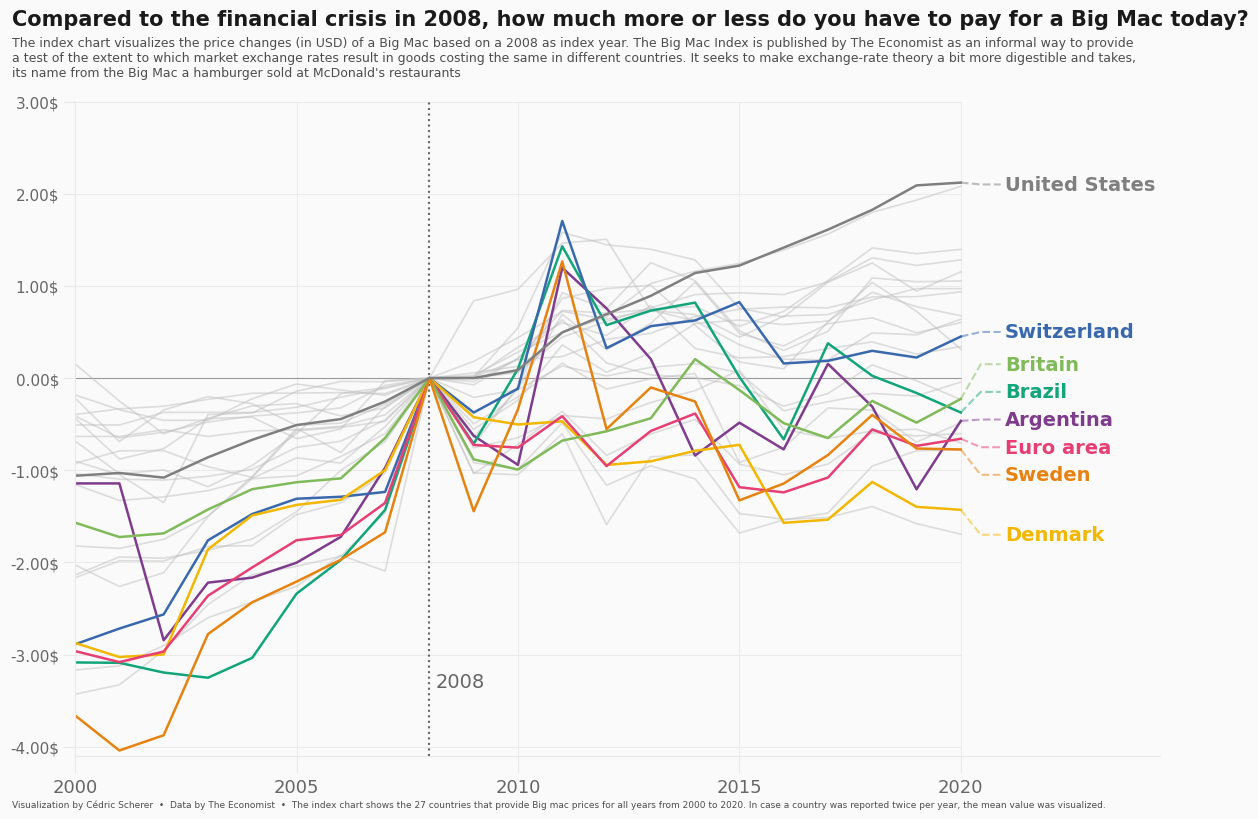

findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

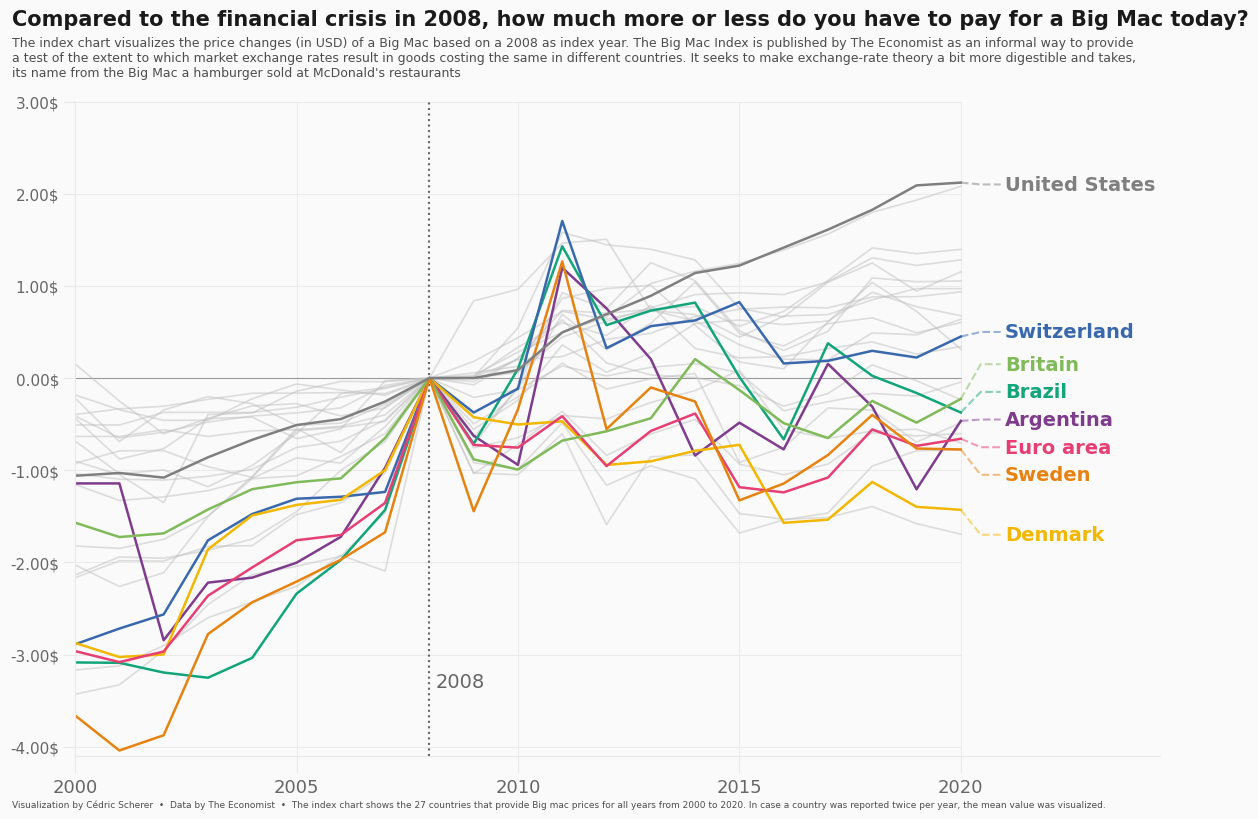

In [750]:
df_mac_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-12-22/big-mac.csv"
)
# A list of country/zones that are going to be highlighted
HIGHLIGHTS = ["EUZ", "CHE", "DNK", "SWE", "BRA", "ARG", "GBR", "USA"]

df_mac_raw["year"] = pd.DatetimeIndex(df_mac_raw["date"]).year

# Subset variables
df_mac_raw = df_mac_raw[["date", "year", "iso_a3", "currency_code", "name", "dollar_price"]]

# If there is more than one record per year/country, use the mean
df_mac = df_mac_raw.groupby(["iso_a3", "name", "year"]).agg(
    price = ("dollar_price", "mean")
).reset_index()

# Keep countries/regions with records for the last 21 years  
# (from 2000 to 2020 inclusive)
group_sizes = df_mac.groupby("iso_a3").size()
keep = (group_sizes[group_sizes == 21]).index.tolist()
df_mac = df_mac[df_mac["iso_a3"].isin(keep)]

# Keep countries that have a record for 2008, the index year.
countries = df_mac[df_mac["year"] == 2008]["iso_a3"].tolist()
df_mac_indexed_2008 = df_mac[df_mac["iso_a3"].isin(countries)]
df_mac_indexed_2008["ref_year"] = 2008

# For each country/region, obtain the price for 2008
df_price_index = df_mac_indexed_2008.groupby("iso_a3").apply(
   lambda x: x.iloc[np.where(x["year"] == 2008)]
).reset_index(drop=True)

# Rename this price to 'price_index'
df_price_index.rename(columns={"price": "price_index"}, inplace=True)

# Keep only 'iso_a3' and 'price_index' in this auxiliary table
df_price_index = df_price_index[["iso_a3", "price_index"]]

# Merge the index price
df_mac_indexed_2008 = pd.merge(df_mac_indexed_2008, df_price_index, on = "iso_a3")

# Compute relative price
df_mac_indexed_2008["price_rel"] = df_mac_indexed_2008["price"] - df_mac_indexed_2008["price_index"]

# Create 'group' to determine which ones are highlighted
df_mac_indexed_2008["group"] = np.where(
    df_mac_indexed_2008["iso_a3"].isin(HIGHLIGHTS),
    df_mac_indexed_2008["iso_a3"],
    "other"
)

# Make 'group' categorical 
df_mac_indexed_2008["group"] = pd.Categorical(
    df_mac_indexed_2008["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
    GREY50     # USA
]

# Vertical lines every 5 years
VLINES = np.arange(2000, 2025, 5)

# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(-4, 4), xmin=2000, xmax=2020, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2000, xmax=2020, color=GREY60, lw=0.8)

# Vertical like at x = 2008
ax.axvline(2008, color=GREY40, ls="dotted")

# Annotations indicating the meaning of the vertical line
ax.text(2008.15, -3.35, "2008", fontname="Montserrat", 
        fontsize=14, fontweight=500, color=GREY40, ha="left")

# Add lines ------------------------------------------------------
# Create one data frame for the highlighted countries, and other
# for non-highlighted countries.
df_highlight = df_mac_indexed_2008[df_mac_indexed_2008["group"] != "other"]
df_others = df_mac_indexed_2008[df_mac_indexed_2008["group"] == "other"]

for group in df_others["iso_a3"].unique():
    data = df_others[df_others["iso_a3"] == group]
    ax.plot("year", "price_rel", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[df_highlight["iso_a3"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("year", "price_rel", color=color, lw=1.8, data=data)

# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(2000, 2024.5)
ax.set_ylim(-4.1, 3)

# Positions
LABEL_Y = [
    -0.45,  # ARG
    -0.15,  # BRA
    0.5,    # CHE
    -1.7,   # DNK
    -0.75,  # EUZ
    0.15,   # GBR
    -1.05,  # SWE
    2.1     # USA
]

x_start = 2020
x_end = 2021
PAD = 0.1

# Add labels for highlighted countries honly
for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[(df_highlight["iso_a3"] == group) & (df_highlight["year"] == 2020)]
    color = COLOR_SCALE[idx]
    
    # Country name
    text = data["name"].values[0]
    
    # Vertical start of line
    y_start = data["price_rel"].values[0]
    # Vertical end of line
    y_end = LABEL_Y[idx]
    
    # Add line based on three points
    ax.plot(
        [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD], 
        [y_start, y_end, y_end], 
        color=color, 
        alpha=0.5, 
        ls="dashed"
    )
    
    # Add country text
    ax.text(
        x_end, 
        y_end, 
        text, 
        color=color, 
        fontsize=14, 
        weight="bold", 
        fontfamily="Montserrat", 
        va="center"
    )

# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.arange(-4, 4)])
ax.set_yticklabels(
    [f"{y}.00$" for y in np.arange(-4, 4)], 
    fontname="Montserrat", 
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in np.arange(2000, 2025, 5)])
ax.set_xticklabels(
    [x for x in np.arange(2000, 2025, 5)], 
    fontname= "Montserrat", 
    fontsize=13,
    weight=500,
    color=GREY40
)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "The index chart visualizes the price changes (in USD) of a Big Mac based on a 2008 as index year. The Big Mac Index is published by The Economist as an informal way to provide",
    "a test of the extent to which market exchange rates result in goods costing the same in different countries. It seeks to make exchange-rate theory a bit more digestible and takes,", 
    "its name from the Big Mac a hamburger sold at McDonald's restaurants", 
]

fig.text(
    0.08,
    0.97,
    "Compared to the financial crisis in 2008, how much more or less do you have to pay for a Big Mac today?",
    color=GREY10,
    fontsize=15,
    fontname="Montserrat",
    weight="bold"
)

fig.text(
    0.08,
    0.91,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontname="Montserrat",
    fontsize=9,
)

fig.text(
    0.08, 
    0.05, 
    "Visualization by Cédric Scherer  •  Data by The Economist  •  The index chart shows the 27 countries that provide Big mac prices for all years from 2000 to 2020. In case a country was reported twice per year, the mean value was visualized.", 
    fontname="Montserrat", 
    fontsize=6.5, 
    color=GREY30, 
    ha="left"
)

fig